In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import plotly.express as ex

from tqdm.cli import tqdm
from glob import glob
from sklearn.manifold import TSNE
from plotly import express as ex
from os import path as pathlib,walk

%matplotlib inline

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,Callback

In [3]:
class Dataset(object):
    """
    Dataset wrapper to read images from folder and structure it.
    """
    def __init__(self,path,n_faces,resize=128):
        self.path = pathlib.abspath(path)
        self.resize = resize

    def __repr__(self,):
        return f"Dataset Parser @ {self.path}"
        
    def parse(self,progress_bar=True):
        w = walk(self.path)
        self.data = np.array([[[r,pathlib.join(r,f_)] for f_ in f] for r,_,f in list(w)[1:]]).reshape(-1,2)
        self.y = np.array(self.data[:,0])
        self.x = np.array([
            cv2.cvtColor(
                cv2.resize(
                    cv2.imread(
                        i
                    ),
                    (self.resize,self.resize)
                ),
                cv2.COLOR_BGR2RGB
            ) / 255
            for 
                i
            in 
                (tqdm(self.data[:,1]) if progress_bar else self.data[:,1])
        ]).astype(np.float32).mean(axis=-1).reshape(-1, 128, 128, 1)
        return self
            

In [4]:
dataset = Dataset("./images/train/",200)

In [5]:
dataset.parse(progress_bar=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1326.10it/s]


Dataset Parser @ C:\workspace\facedet\notebooks\images\train

### Base Network

In [6]:
class LargeTanH(keras.layers.Layer):
    def call(self,x):
        x = tf.math.tanh(x)
        x = tf.multiply(x, 64)
        return x

In [7]:
def conv(x, filters, kernel_size=3):
    x = Conv2D( filters, kernel_size, padding='same', )(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    return x
    
def block(x, filters, ):
    dx = conv(x, filters, )    
    x = Concatenate()([ x, dx ])
    x = conv(x, filters, 1)
    x = MaxPool2D()(x)
    
    return x

def base_network(d=64):

    im_in = Input(shape=(128,128,1))
    
    b1 = block( im_in, 32 )
    b2 = block( b1, 64 )
    b3 = block( b2, 128 )
    b4 = block( b3, 256 )
    
    out = GlobalAveragePooling2D()(b4)
    out = Dense(1024, )(out)
    out = BatchNormalization()(out)
    out = Activation('tanh')(out)
    out = Dense( d, )(out)
    out = BatchNormalization()(out)
    out = LargeTanH()(out)
    
    model = keras.Model(im_in,out)
    
    return model

In [8]:
class Pairs(object):
    def __init__(self,model:tf.keras.Model,x:np.ndarray,y:np.ndarray,size:int=128):
        self.x = x.reshape(-1,size, size,1) 
        self.y = y
        self.dummy = np.array([[0]])
        
        self.model = model
        self.size = size
        
    def generate_pairs(self,):
        pass
    
    def flow(self,):
        while True:
            emb = self.model.predict(self.x)
            score = tf.math.abs(tf.reduce_mean(emb - tf.reshape(emb, shape=(-1, 1, 64)), axis=-1)).numpy()
            ps = []
            for a,( dy , de ) in enumerate(zip(self.y,score)):
                p_index, = np.where( self.y == dy )
                n_index, = np.where( self.y != dy )
                p = p_index[de[p_index].argmax()]
                n = n_index[de[n_index].argmin()]
                ps.append((a,p,n))
                
            ps = np.array(ps).reshape(-1,10,3)
            np.random.shuffle(ps)
            for idx in ps:
                yield ( self.x[idx[:,0]], self.x[idx[:,1]], self.x[idx[:,2]] ), self.dummy            

In [9]:
model = base_network()
pairs = Pairs(model,dataset.x,dataset.y)
flow = pairs.flow()

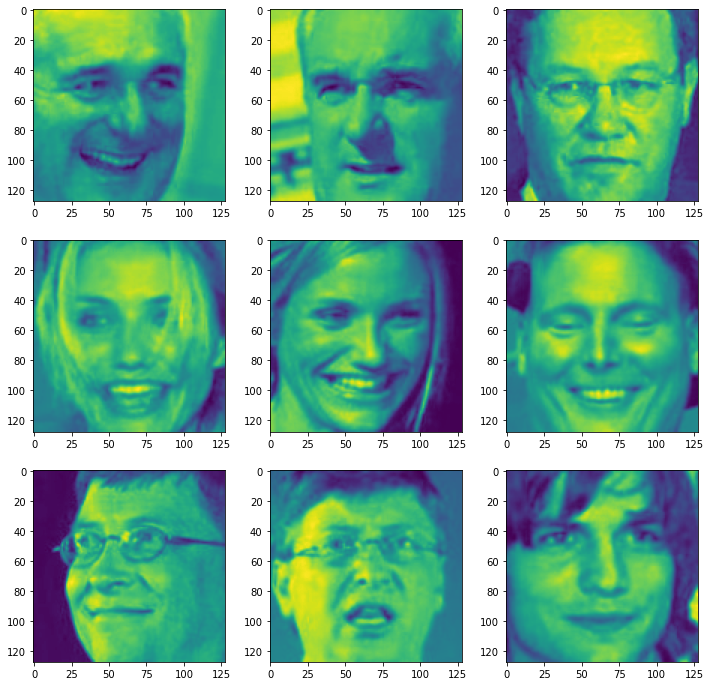

In [10]:
fig,axes = plt.subplots(3,3,figsize=(12,12))

for ax in axes:
    (a,p,n),r = next(flow)
    ax[0].imshow(a[0].reshape(128, 128))
    ax[1].imshow(p[0].reshape(128, 128))
    ax[2].imshow(n[0].reshape(128, 128))

In [11]:
class Triplet(tf.Module):
    """
    Triplet Loss
    """
    __name__ = "TripletLoss"
    def __init__(self,d,margin=.75):
        self.d = d
        self.margin = margin
        self.l2 = keras.losses.MeanAbsoluteError()
 
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        a,p,n = tf.unstack(tf.reshape(y_pred,(3,-1,self.d)))
        Dp = self.l2(a,p)
        Dn = self.l2(a,n)
        return tf.nn.relu(Dp - Dn + self.margin)

In [12]:
model = base_network()

a_inp = Input(shape=(128, 128,1),name="anc")
p_inp = Input(shape=(128, 128,1),name="pos")
n_inp = Input(shape=(128, 128,1),name="neg")

a_net = model(a_inp)
p_net = model(p_inp)
n_net = model(n_inp)

out = concatenate([a_net,p_net,n_net],name="out")
train = keras.Model([a_inp,p_inp,n_inp],out)

In [36]:
ckp = ModelCheckpoint(filepath="./checkpoints/facenet",save_weights_only=True)

opt = keras.optimizers.Adagrad(.0001)
triplet = Triplet(d=64,margin=8)
train.compile(optimizer=opt,loss=triplet)

In [37]:
epochs = 300

pairs = Pairs(model,dataset.x,dataset.y)
flow = pairs.flow()

In [38]:
history = train.fit_generator(flow,steps_per_epoch=45,epochs=epochs,callbacks=[ckp])

Epoch 1/300
45/45 [==============================] - 7s 90ms/step - loss: 7.8824
Epoch 2/300
45/45 [==============================] - 4s 90ms/step - loss: 7.5533
Epoch 3/300
45/45 [==============================] - 4s 89ms/step - loss: 5.6603
Epoch 4/300
45/45 [==============================] - 4s 91ms/step - loss: 6.9523
Epoch 5/300
45/45 [==============================] - 4s 91ms/step - loss: 4.5859
Epoch 6/300
45/45 [==============================] - 4s 94ms/step - loss: 4.7416
Epoch 7/300
45/45 [==============================] - 4s 90ms/step - loss: 4.2585
Epoch 8/300
45/45 [==============================] - 4s 90ms/step - loss: 4.7855
Epoch 9/300
45/45 [==============================] - 4s 91ms/step - loss: 4.8180
Epoch 10/300
45/45 [==============================] - 4s 90ms/step - loss: 4.6529
Epoch 11/300
45/45 [==============================] - 4s 90ms/step - loss: 4.4755
Epoch 12/300
45/45 [==============================] - 4s 90ms/step - loss: 3.5368
Epoch 13/300
45/45 [=====

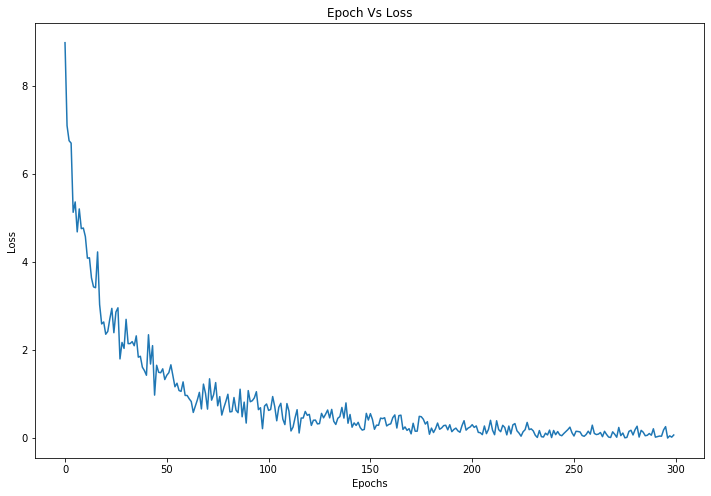

In [50]:
plt.figure(figsize=(12,8))
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch Vs Loss");

In [13]:
model.save("./model.hdf5",)